# Preprocessing
-------------------

This part of the notebook focuses on preprocessing data.

## Importing libraries

In [2]:
import pickle
import os

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, LSTM, Conv1D, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy import stats


os.chdir('/kaggle/input/electrical-power-quality-meter-dataset')
print(os.listdir('.'))
        
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


['power-quality-meter.csv']


## Loading and cleaning data

In [3]:
data = pd.read_csv('power-quality-meter.csv')

# Dropping Phase angle values as they have little effect
input_data = data.drop(['Date','Time','Cos Phi AN Avg','Cos Phi BN Avg','Cos Phi CN Avg','Cos Phi Total Avg'], axis = 1)
input_data.drop(input_data.columns[0], inplace=True, axis=1)

# Dropping outliers
input_data = input_data[(np.abs(stats.zscore(input_data)) < 3).all(axis=1)]

print(list(input_data.columns.values))

# Dump a pickle of dataset labels
with open('/kaggle/working/labels.pickle', "wb+") as pickle_out:
    pickle.dump(list(input_data.columns.values), pickle_out)


['Vrms ph-n AN Avg', 'Vrms ph-n BN Avg', 'Vrms ph-n CN Avg', 'Vrms ph-n NG Avg', 'Current A Avg', 'Current B Avg', 'Current C Avg', 'Current Phi AN Avg', 'Current Phi BN Avg', 'Current Phi CN Avg', 'Active Power Total Avg', 'Apparent Power Total Avg', 'Reactive Power Total Avg']


## Preprocessing and conversion to supervised learning problem

In [4]:
# Scaling data
scaler = StandardScaler()
scaler.fit(input_data[:3*len(input_data)//4]) # 0.75 because train_size is 75% of given data
copy = scaler.transform(input_data)

timestep = 10

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)   
        
    return agg

train = series_to_supervised(copy).values
print(np.array(train).shape)

(2300, 26)


## Train-test split and dump data

In [5]:
X_train = []
y_train = []

for i in range(timestep, len(input_data)-1):
    X_train.append(train[i-timestep:i, :len(input_data.columns)])
    y_train.append(train[i-timestep, len(input_data.columns):])
    
X_train, y_train = np.array(X_train), np.array(y_train)

data_dump = X_train, y_train

with open("/kaggle/working/data.pickle","wb+") as pickle_out:
    pickle.dump(data_dump, pickle_out)

with open("/kaggle/working/scaler.pickle","wb+") as pickle_out:
    pickle.dump(scaler, pickle_out)

# Training
------------------
This section of the kernel focuses on training and validating the model

## Load preprocessed data

In [6]:
with open("/kaggle/working/data.pickle", "rb") as f:
    X_train, y_train = pickle.load(f)

## Define and compile model

In [7]:
model = Sequential()
model.add(LSTM(512, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(256, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(X_train.shape[2]))

model.compile(loss = 'mae', optimizer = Adam(lr = 1e-3))

## Fit model

In [10]:
# Model checkpoint callback to save model with lowest validation loss
cp_callbacks = ModelCheckpoint(filepath = "/kaggle/working/model.h5", monitor = "val_loss", mode = 'min', save_best_only = True, verbose = 1)

# Fit model
history = model.fit(X_train, y_train, epochs = 90, batch_size = 256, validation_split = 0.25, callbacks = [cp_callbacks])

Train on 1717 samples, validate on 573 samples
Epoch 1/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0582
Epoch 00001: val_loss improved from inf to 0.13163, saving model to /kaggle/working/model.h5
1717/1717 [==============================] - 0s 109us/sample - loss: 0.0578 - val_loss: 0.1316
Epoch 2/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0585
Epoch 00002: val_loss improved from 0.13163 to 0.13034, saving model to /kaggle/working/model.h5
1717/1717 [==============================] - 0s 113us/sample - loss: 0.0586 - val_loss: 0.1303
Epoch 3/90
1280/1717 [=====================>........] - ETA: 0s - loss: 0.0586
Epoch 00003: val_loss did not improve from 0.13034
1717/1717 [==============================] - 0s 133us/sample - loss: 0.0584 - val_loss: 0.1385
Epoch 4/90
1280/1717 [=====================>........] - ETA: 0s - loss: 0.0580
Epoch 00004: val_loss improved from 0.13034 to 0.12972, saving model to /kaggle/working/model.h5
1717/1717 [===

Epoch 36/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0490
Epoch 00036: val_loss did not improve from 0.10800
1717/1717 [==============================] - 0s 57us/sample - loss: 0.0491 - val_loss: 0.1230
Epoch 37/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0489
Epoch 00037: val_loss did not improve from 0.10800
1717/1717 [==============================] - 0s 62us/sample - loss: 0.0489 - val_loss: 0.1179
Epoch 38/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0486
Epoch 00038: val_loss did not improve from 0.10800
1717/1717 [==============================] - 0s 58us/sample - loss: 0.0484 - val_loss: 0.1110
Epoch 39/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0489
Epoch 00039: val_loss did not improve from 0.10800
1717/1717 [==============================] - 0s 59us/sample - loss: 0.0487 - val_loss: 0.1107
Epoch 40/90
1280/1717 [=====================>........] - ETA: 0s - loss: 0.0494
Epoch 00040: val_los

1536/1717 [=========================>....] - ETA: 0s - loss: 0.0467
Epoch 00071: val_loss did not improve from 0.09599
1717/1717 [==============================] - 0s 56us/sample - loss: 0.0466 - val_loss: 0.0995
Epoch 72/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0475
Epoch 00072: val_loss did not improve from 0.09599
1717/1717 [==============================] - 0s 55us/sample - loss: 0.0474 - val_loss: 0.0981
Epoch 73/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0465
Epoch 00073: val_loss improved from 0.09599 to 0.09566, saving model to /kaggle/working/model.h5
1717/1717 [==============================] - 0s 100us/sample - loss: 0.0465 - val_loss: 0.0957
Epoch 74/90
1536/1717 [=========================>....] - ETA: 0s - loss: 0.0445
Epoch 00074: val_loss did not improve from 0.09566
1717/1717 [==============================] - 0s 61us/sample - loss: 0.0446 - val_loss: 0.0966
Epoch 75/90
1536/1717 [=========================>....] - ETA: 0s 

## Validation of data

In [14]:
model = tf.keras.models.load_model("/kaggle/working/model.h5")

validation_target = y_train[3*len(X_train)//4:]
validation_predictions = []
error = []

# index of first validation input
i = 3*len(X_train)//4

while len(validation_predictions) < len(validation_target) - 1:
  p = model.predict(X_train[i].reshape(1, X_train.shape[1], X_train.shape[2]))[0] 
  i += 1
  error.append(mean_absolute_error(p,y_train[i]))

  # update the predictions list
  validation_predictions.append(p)

## Plot mean absolute error

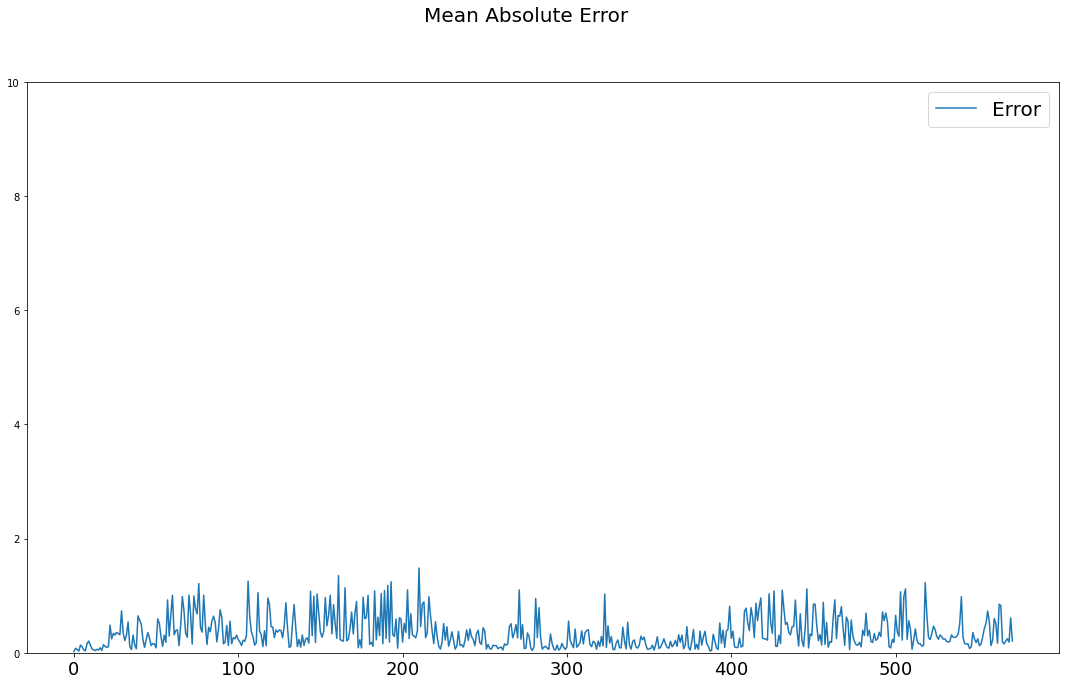

In [15]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Mean Absolute Error', size=20)
plt.plot(error, label='Error')
plt.xticks(fontsize=18)
plt.ylim(0, 10)
plt.legend(prop={'size': 20})
plt.show()

## Plot predicted vs actual values for all parameters

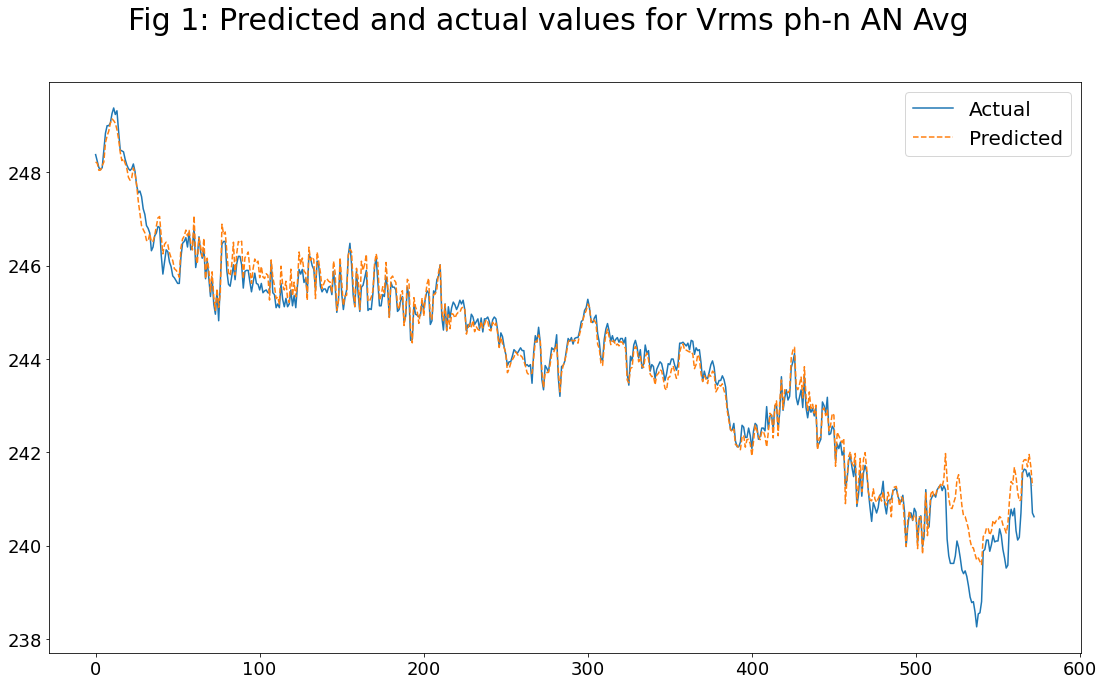

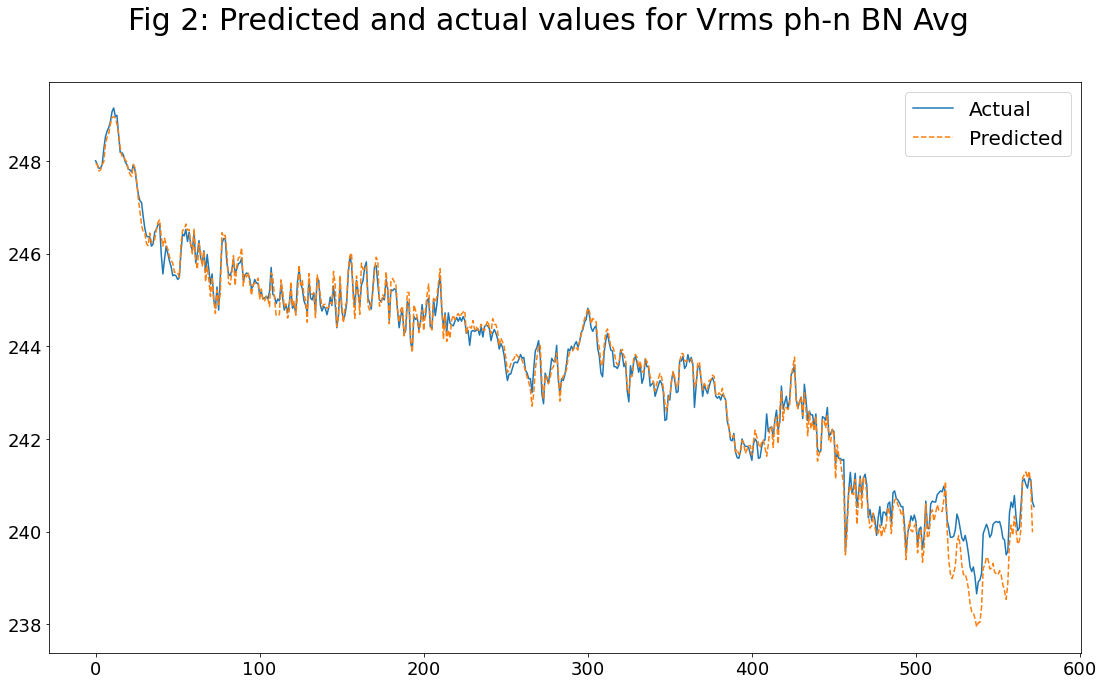

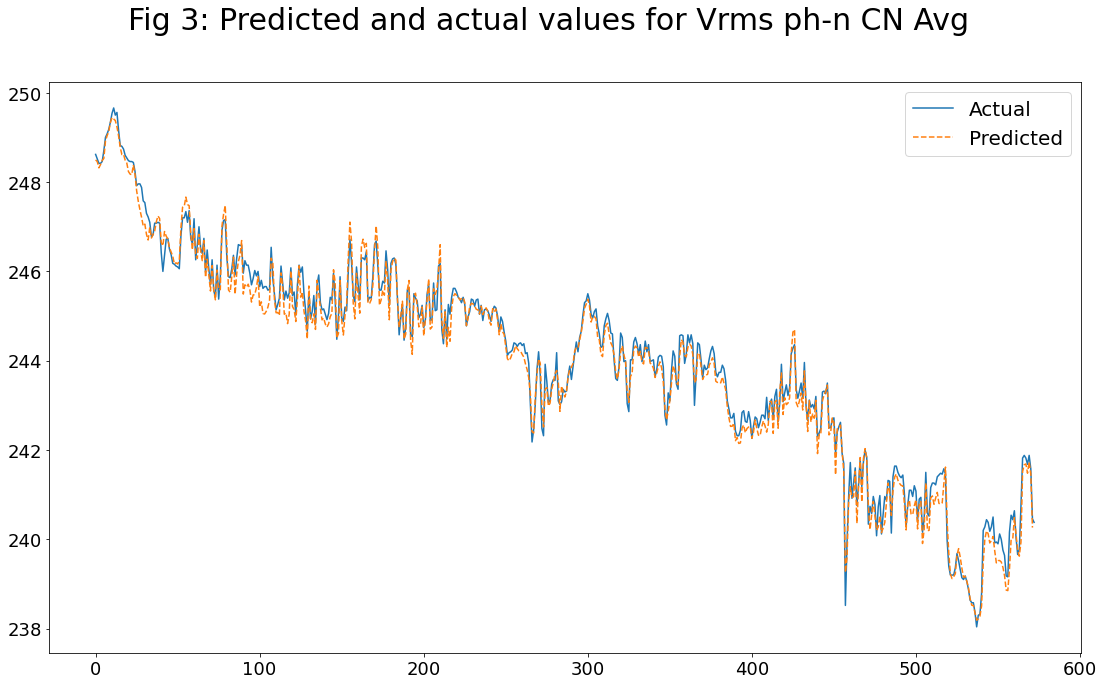

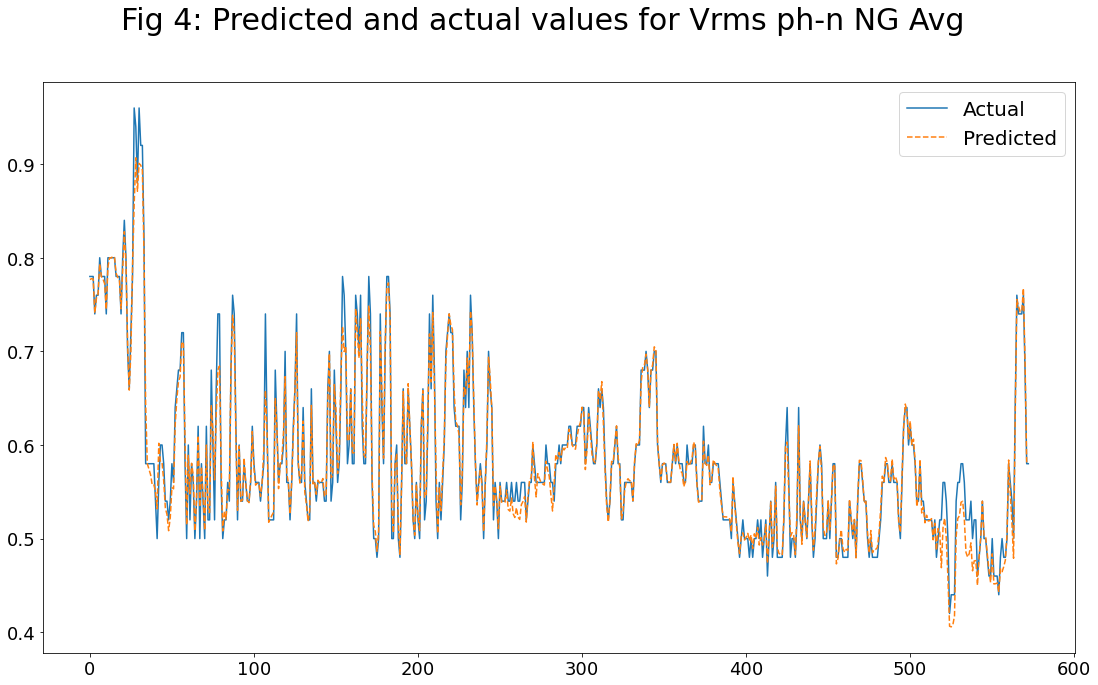

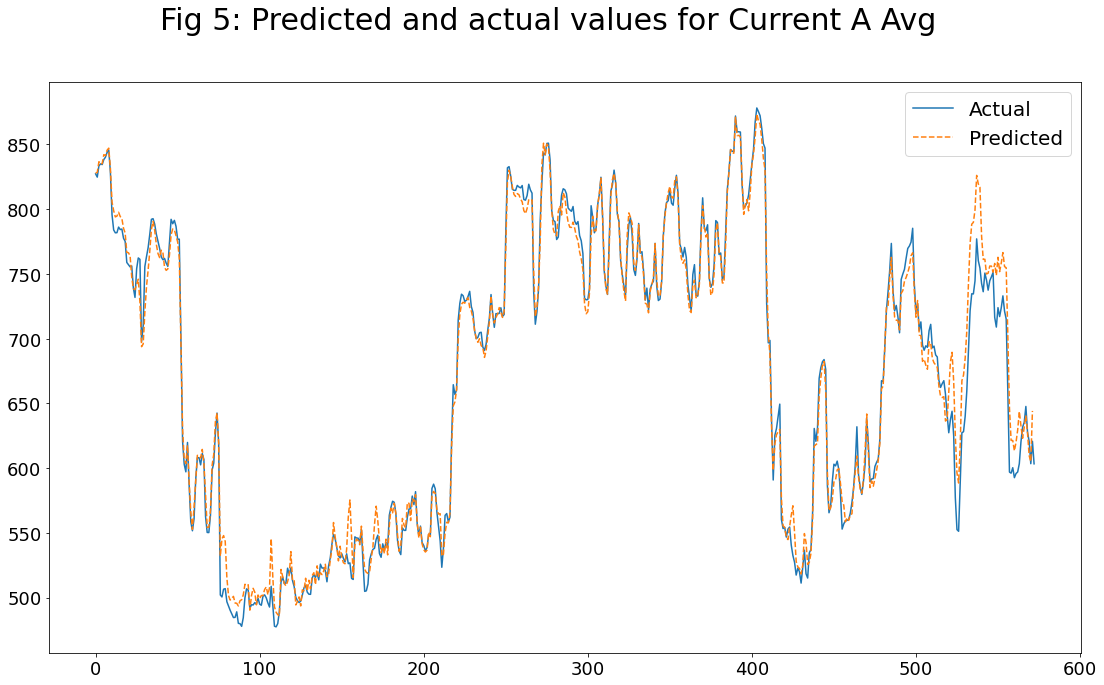

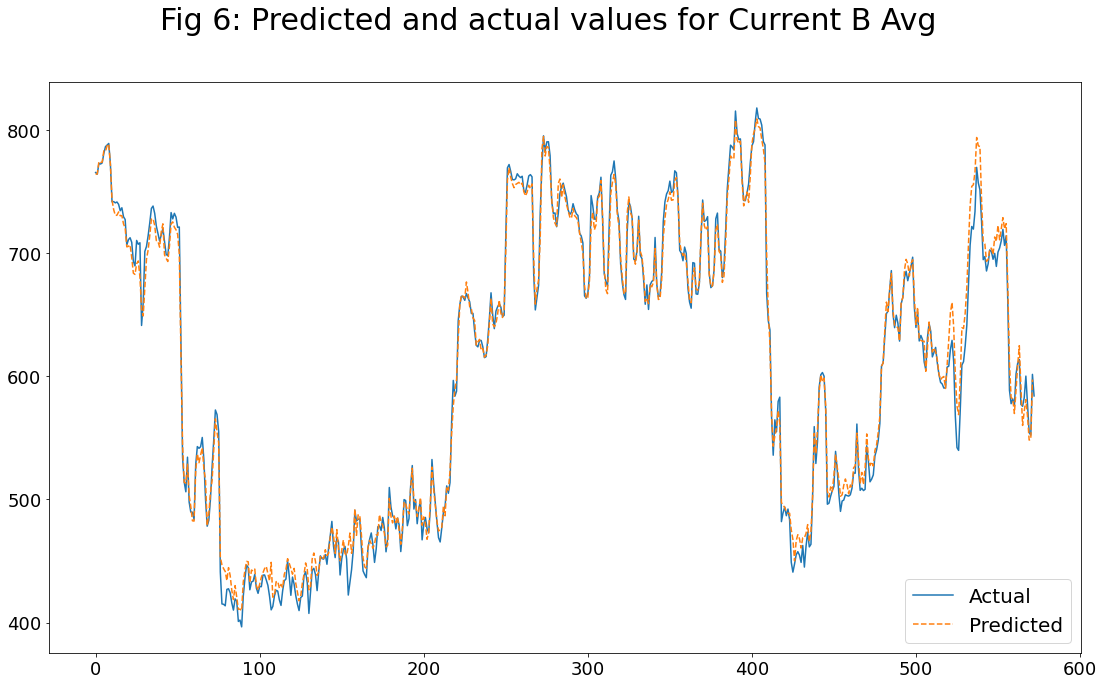

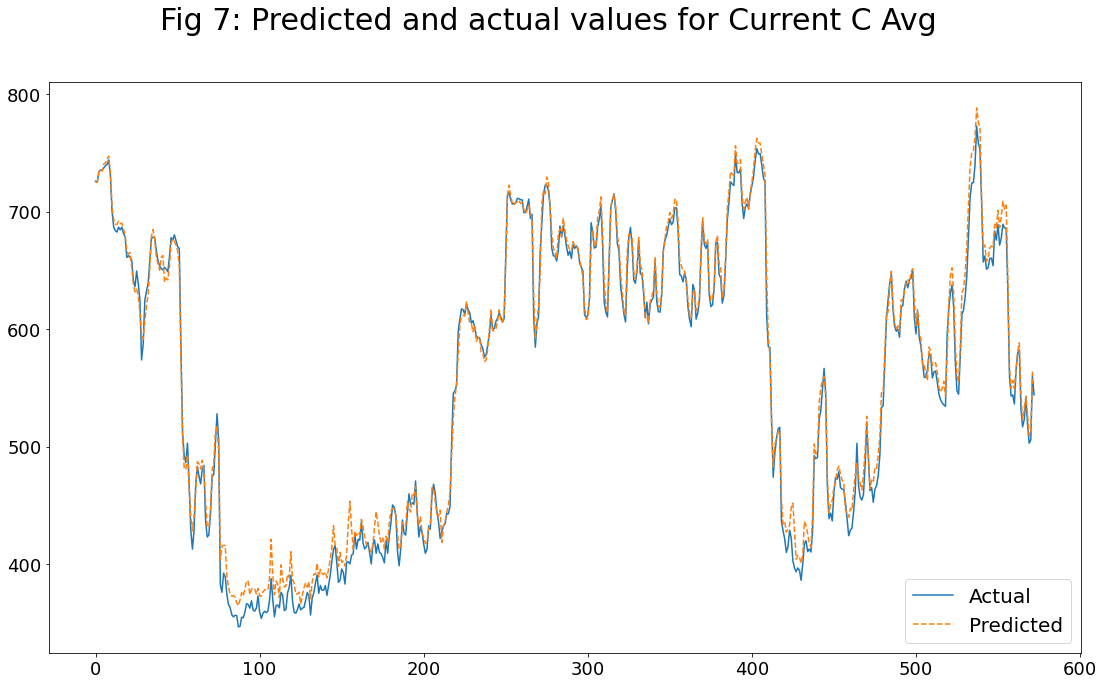

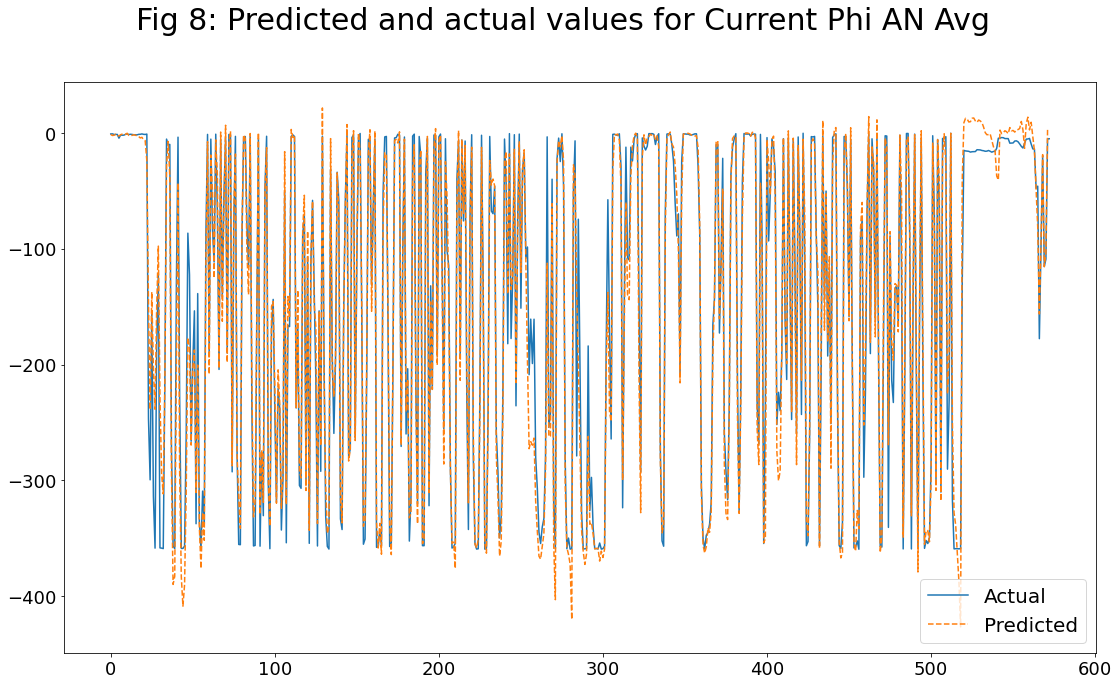

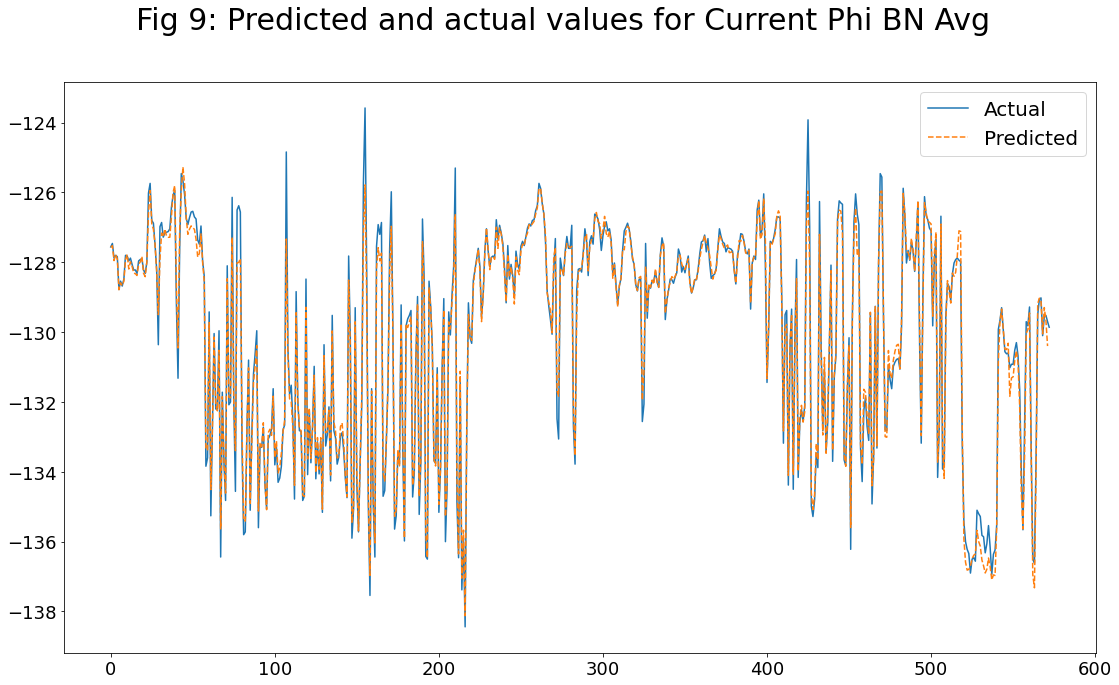

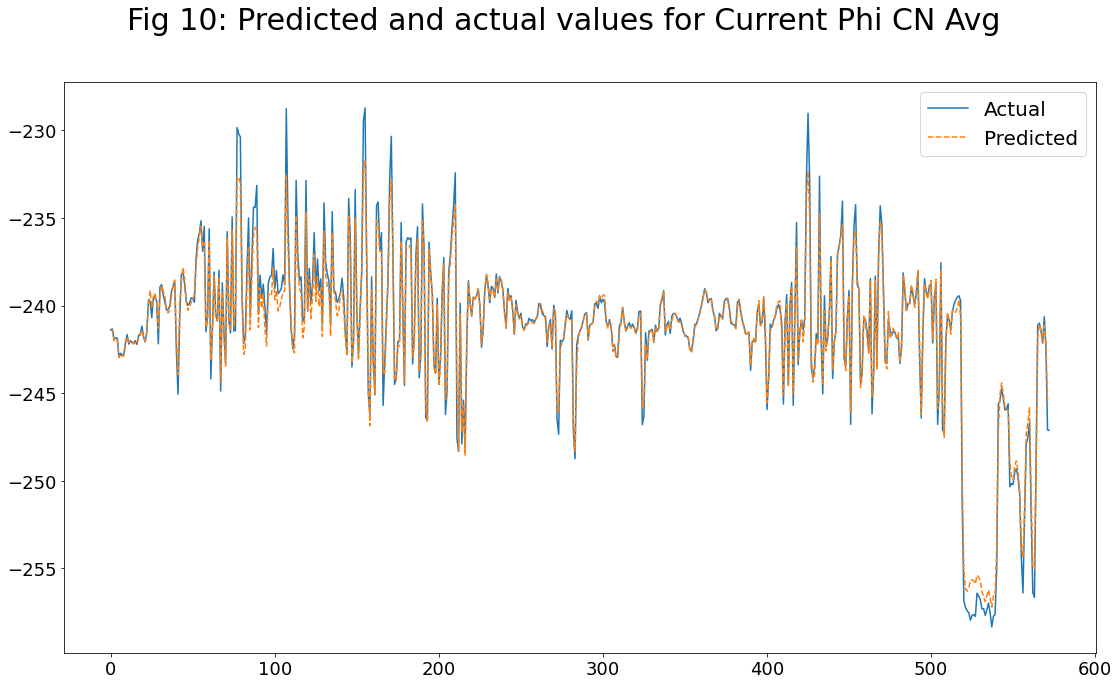

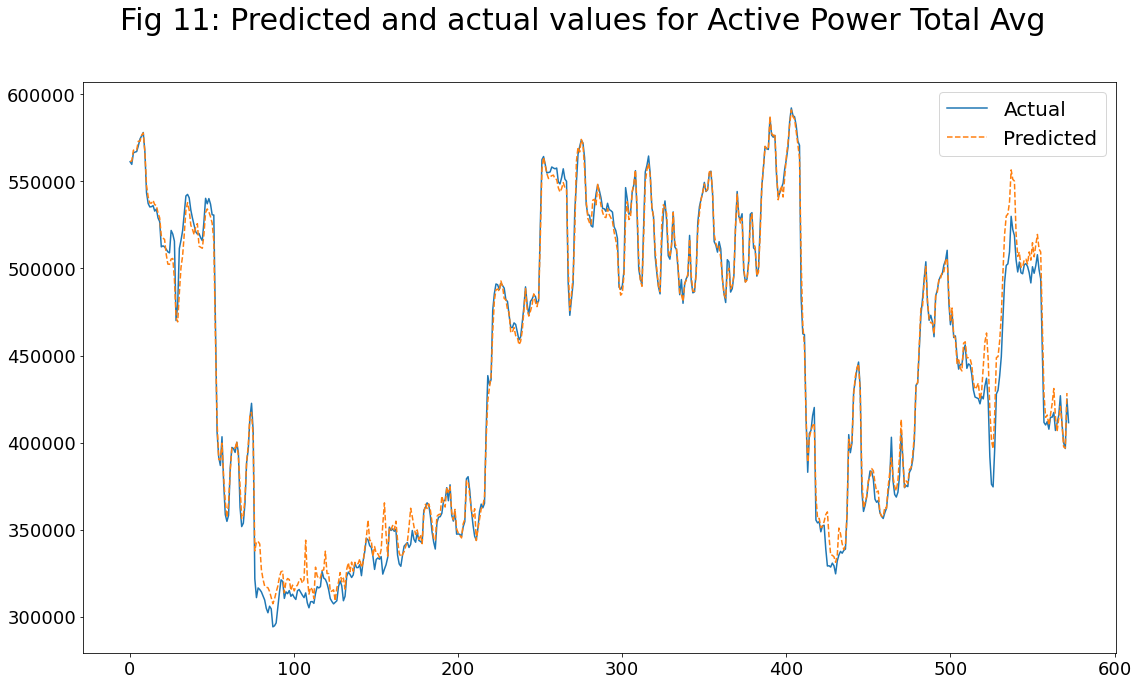

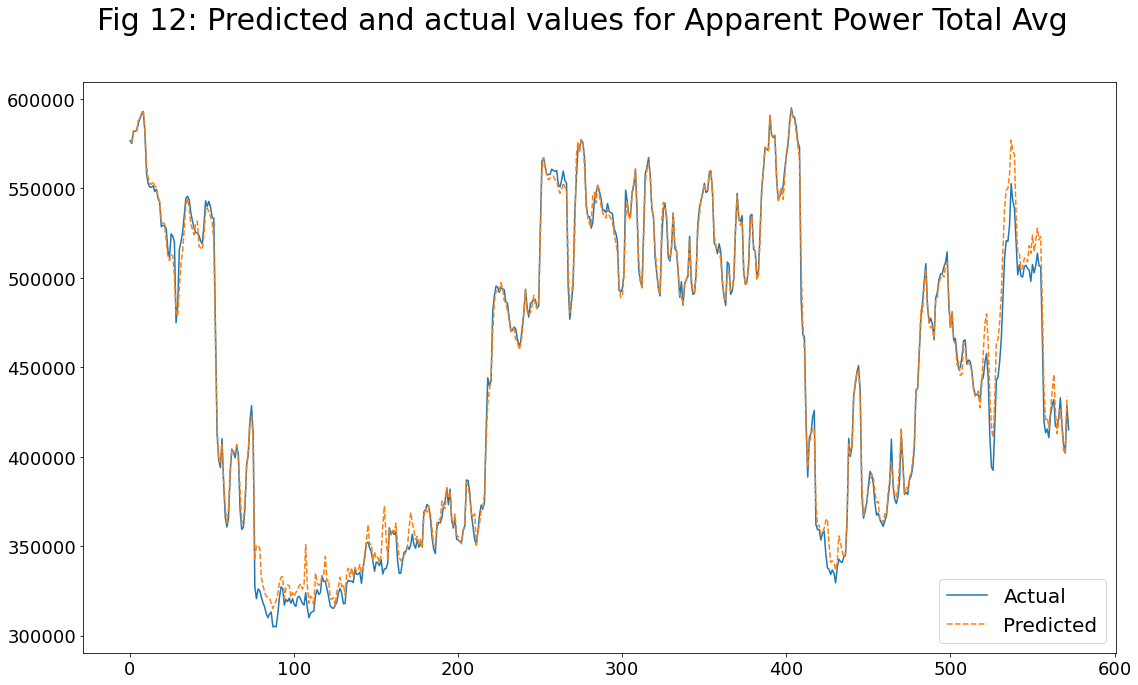

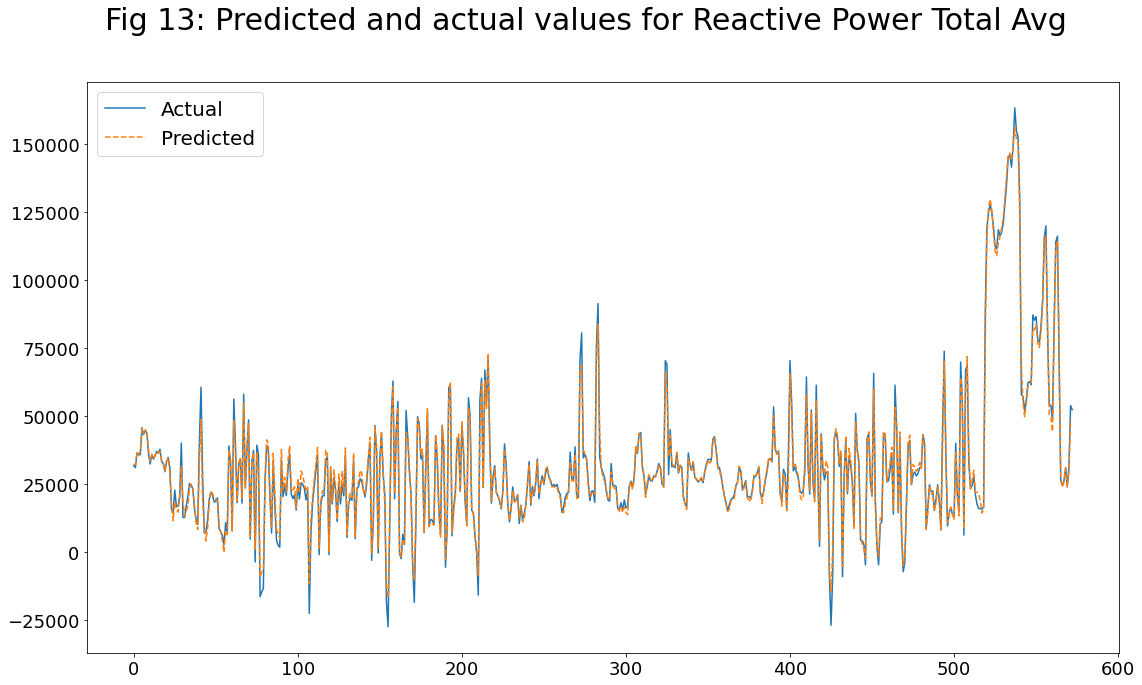

In [16]:
with open('/kaggle/working/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
    
with open('/kaggle/working/labels.pickle', 'rb') as f:
    labels = pickle.load(f)

for i in range(validation_target.shape[1]):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Fig "+str(i+1)+": Predicted and actual values for "+labels[i], size=30)
    plt.plot(scaler.inverse_transform(validation_target)[:, i], label='Actual')
    plt.plot(scaler.inverse_transform(np.array(validation_predictions))[:, i], '--', label='Predicted')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(prop={'size': 20})
    plt.show()

# Conclusion

That's it for the kernel. Feel free to fork and edit, download the model and use it from the outputs. Enjoy yourself.